# Analisis de piez en backlight.

In [1]:
# Cargar librerias.
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

Vamos a definir funciones que nos serán utiles para una mejor manipulación de las imagenes.

In [2]:
def mostrar_imagen(titulo, imagen):
    plt.figure(figsize=(10,8))
    plt.imshow(imagen, cmap='gray')
    plt.title(titulo)
    plt.axis('off')
    plt.show()

def mostrar_histograma(titulo, imagen):
    # calcHist([imagen], [canal], máscara, [tamaño_hist], [rango])
    hist = cv.calcHist([imagen], [0], None, [256], [0,256])

    plt.figure(figsize=(10,4))
    plt.plot(hist, color='black')
    plt.title(titulo)
    plt.xlabel('Intensidad de Píxel (0=Negro, 255=Blanco)')
    plt.ylabel('Cantidad de Píxeles')
    plt.xlim([0,256])
    plt.grid(True)
    plt.show()

¿Cómo son nuestras imagenes?

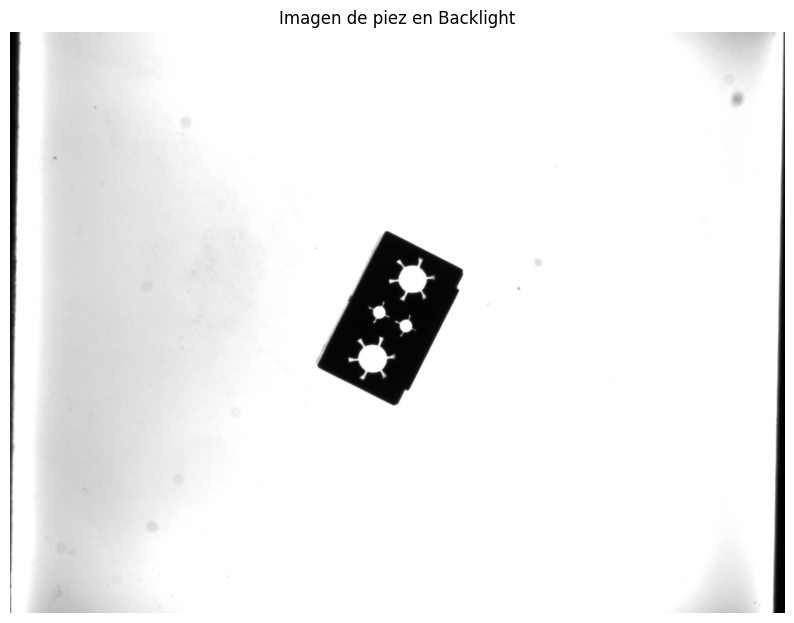

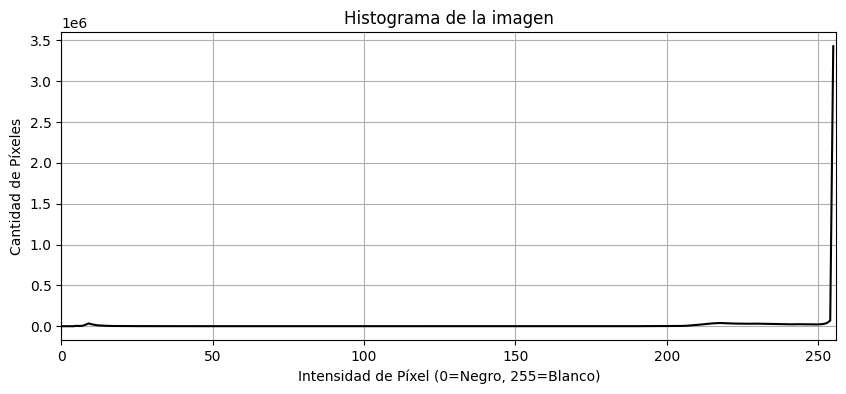

In [6]:
img_backlight = cv.imread('datasets_piezas_te/Molding Fingers/ok/OK_005_2021_09_08_111818_196.jpg', cv.IMREAD_GRAYSCALE)

mostrar_imagen('Imagen de piez en Backlight', img_backlight)
mostrar_histograma('Histograma de la imagen', img_backlight)

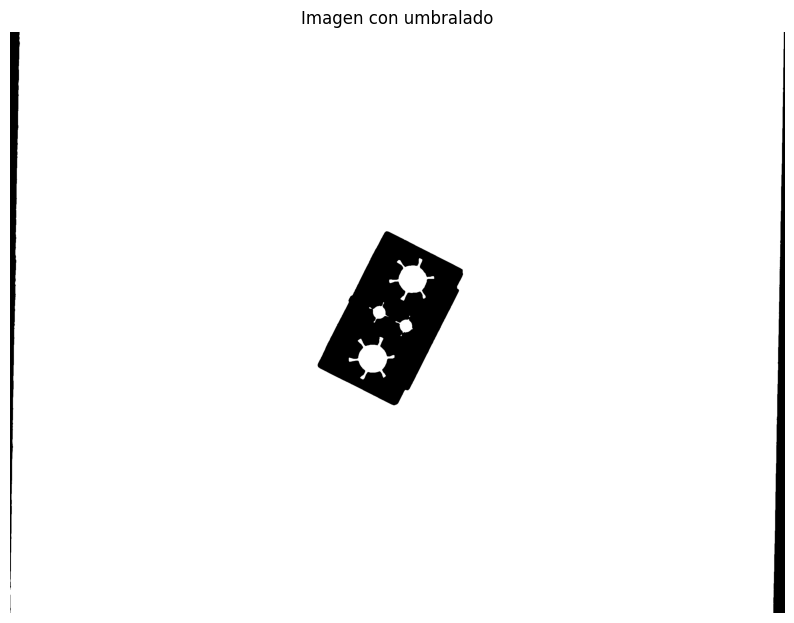

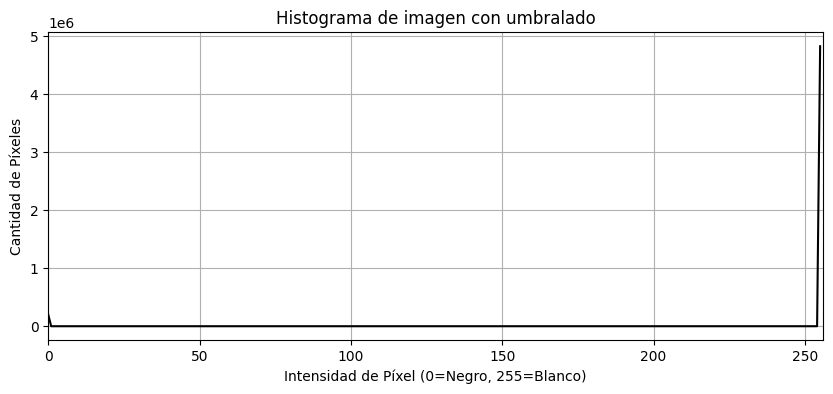

In [7]:
ret, mask_global_otsu = cv.threshold(
    img_backlight,
    0,
    255,
    cv.THRESH_BINARY + cv.THRESH_OTSU
)

mostrar_imagen('Imagen con umbralado', mask_global_otsu)
mostrar_histograma('Histograma de imagen con umbralado', mask_global_otsu)

# 1. Morgología (Limpieza de máscara)

In [17]:
# Necesitamos un kernel. Pequeña matriz que "barre" la imagen.

kernel = np.ones((5,5), np.uint8) + 1
print("Kernel a usar:")
print(kernel)

Kernel a usar:
[[2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]]


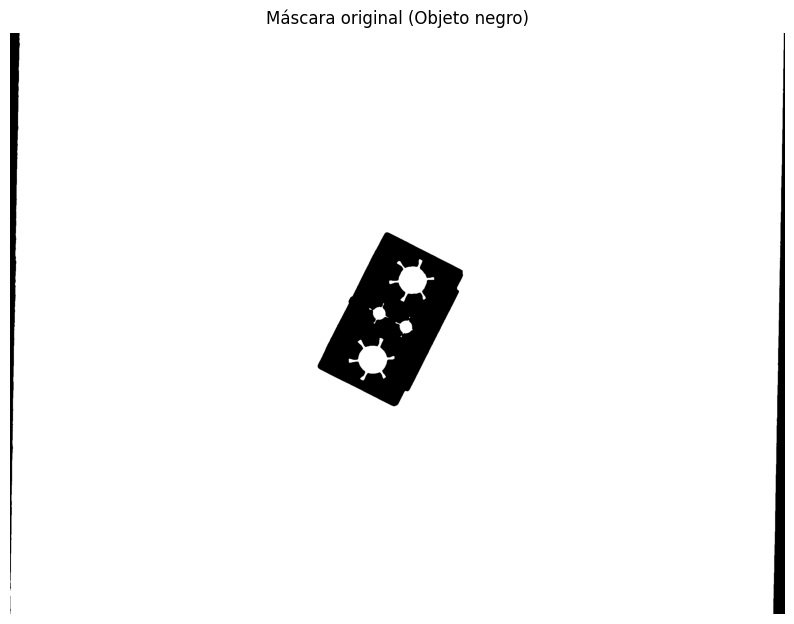

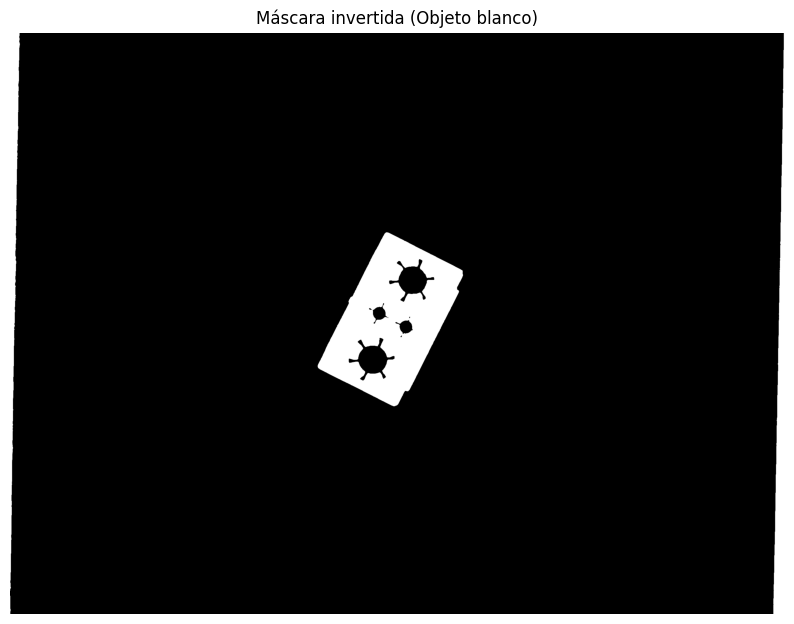

In [18]:
# Invertimos la máscara: lo blanco se vuelve negro y lo negro blanco.
mask_invertida = cv.bitwise_not(mask_global_otsu)

mostrar_imagen("Máscara original (Objeto negro)", mask_global_otsu)
mostrar_imagen("Máscara invertida (Objeto blanco)", mask_invertida)

### Erosión y Dilatación

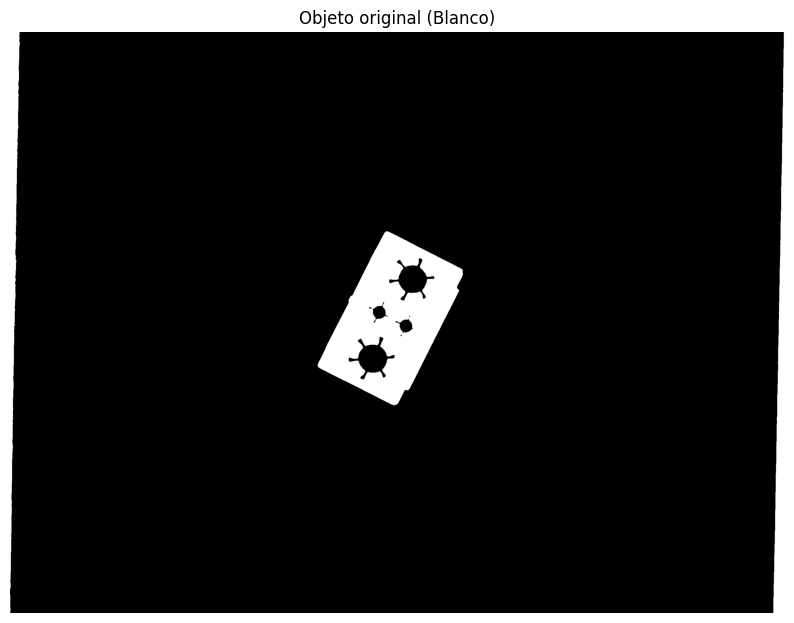

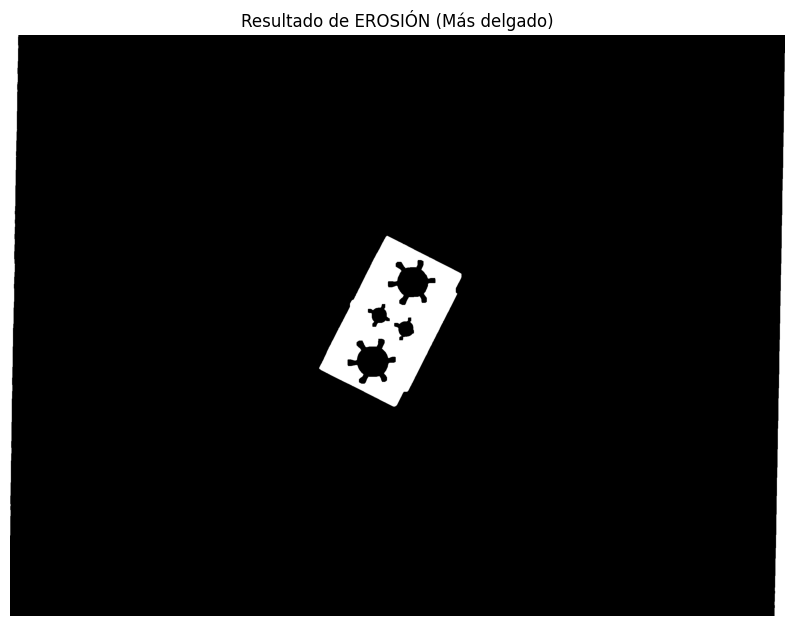

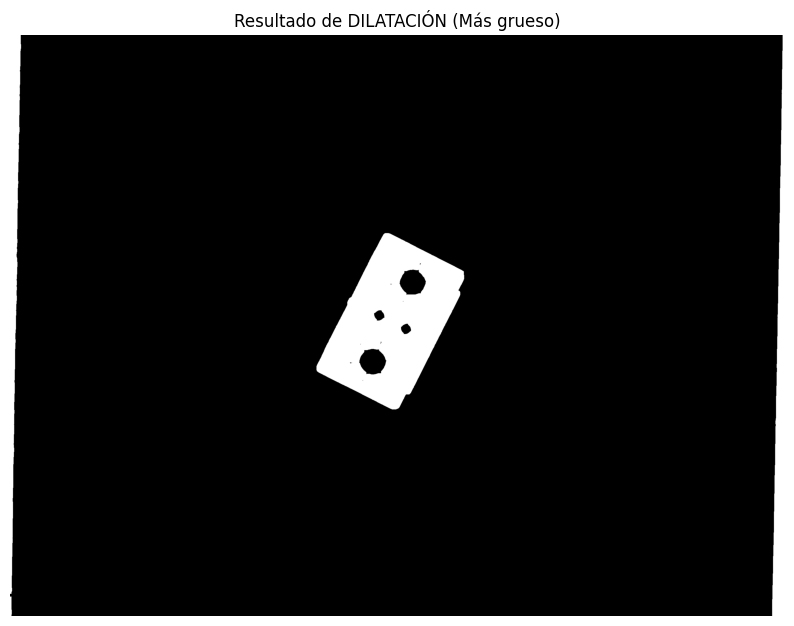

In [19]:
img_erosion = cv.erode(mask_invertida, kernel, iterations=2)

img_dilatada = cv.dilate(mask_invertida, kernel, iterations=2)

mostrar_imagen('Objeto original (Blanco)', mask_invertida)
mostrar_imagen('Resultado de EROSIÓN (Más delgado)', img_erosion)
mostrar_imagen('Resultado de DILATACIÓN (Más grueso)', img_dilatada)

### Operaciones compuestas: Apertura y Cierre

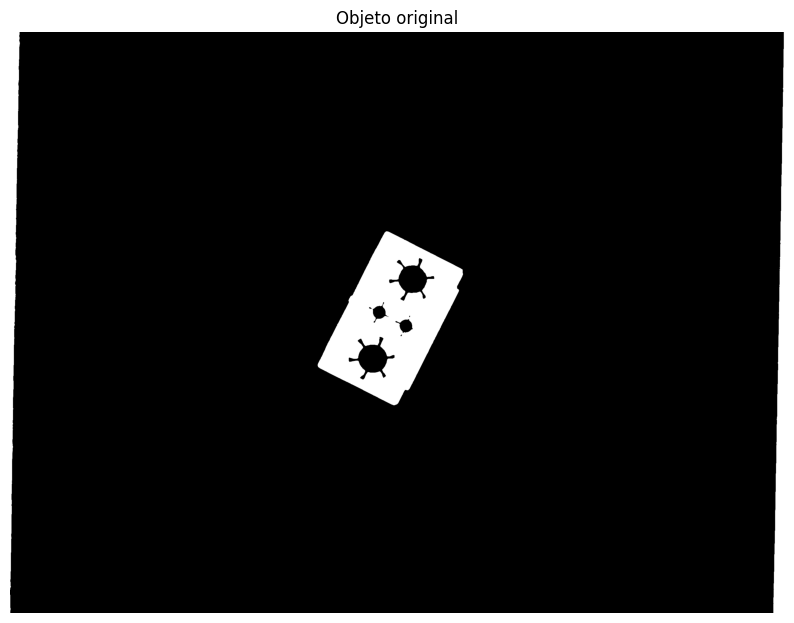

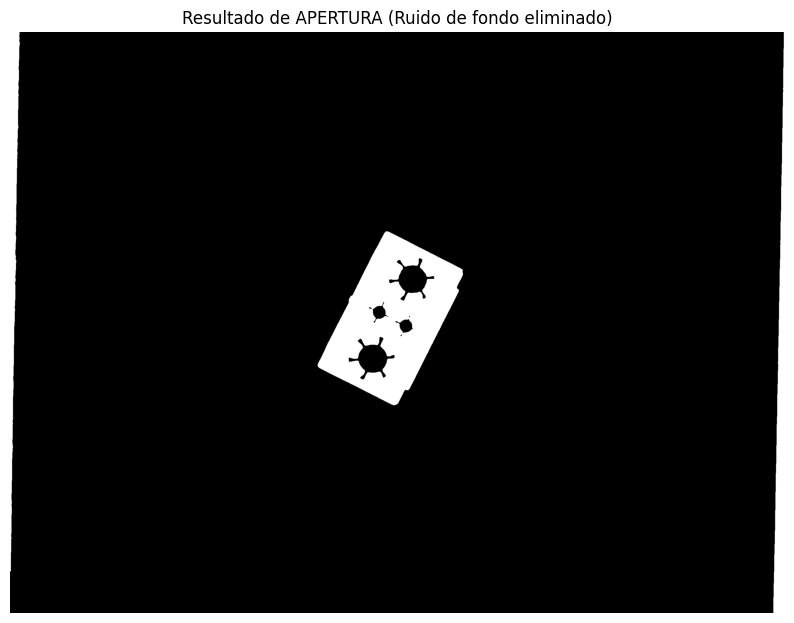

In [20]:
img_apertura = cv.morphologyEx(mask_invertida, cv.MORPH_OPEN, kernel)

mostrar_imagen('Objeto original', mask_invertida)
mostrar_imagen('Resultado de APERTURA (Ruido de fondo eliminado)', img_apertura)

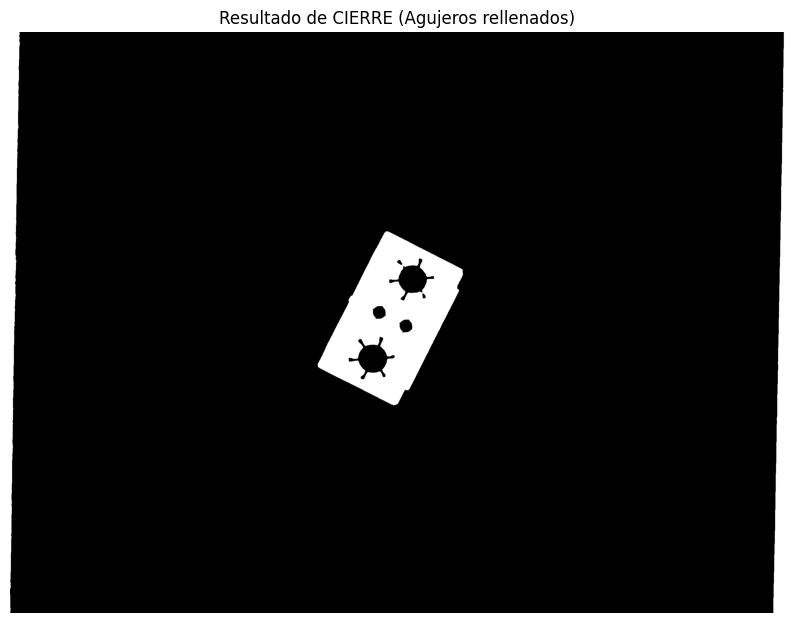

In [21]:
img_cierre = cv.morphologyEx(mask_invertida, cv.MORPH_CLOSE, kernel)

mostrar_imagen('Resultado de CIERRE (Agujeros rellenados)', img_cierre)

# 2. Análisis de Contornos (Detección de Blobs)

Se encontraron 9 contornos en total


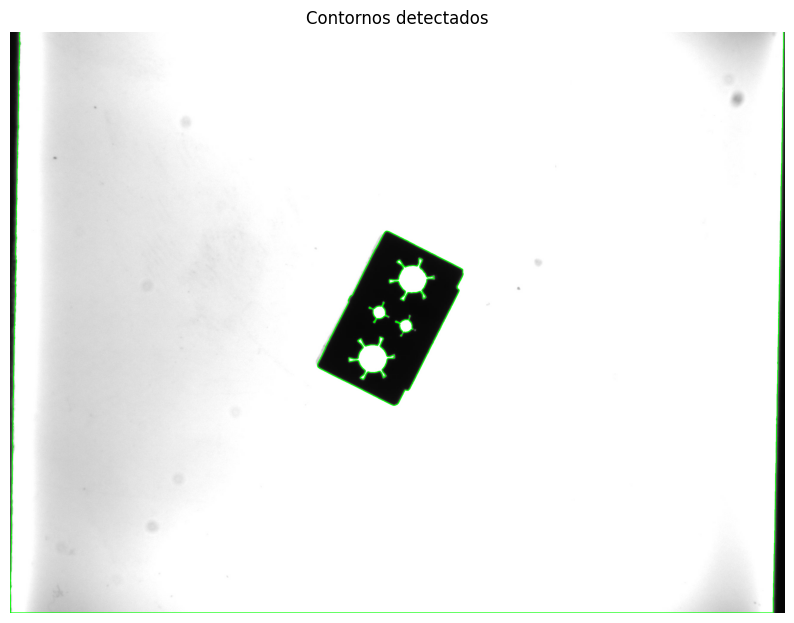

In [22]:
contornos, jerarquia = cv.findContours(
    mask_global_otsu.copy(),
    cv.RETR_LIST,
    cv.CHAIN_APPROX_SIMPLE
)

print(f"Se encontraron {len(contornos)} contornos en total")

img_para_dibujar = cv.cvtColor(img_backlight, cv.COLOR_GRAY2BGR)

cv.drawContours(
    img_para_dibujar,
    contornos,
    -1,
    (0,255,0),
    2
)

mostrar_imagen('Contornos detectados', img_para_dibujar)

Filtrado de contornos por Área.

Contornos totales: 9
Contornos filtrados (agujeros:) 4


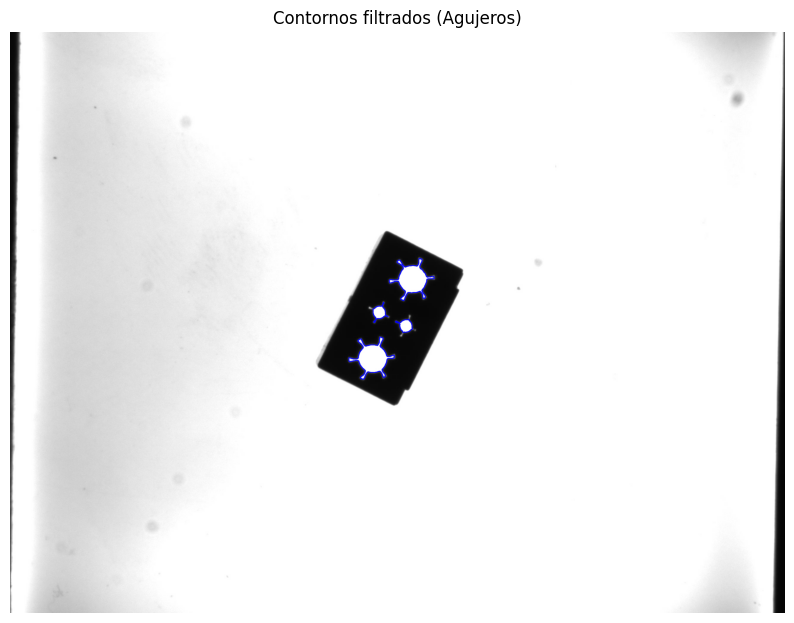

In [23]:
contornos_filtrados = []

AREA_MAXIMA = 10000

for cnt in contornos:
    area = cv.contourArea(cnt)

    if area < AREA_MAXIMA and area > 100:
        contornos_filtrados.append(cnt)

print(f"Contornos totales: {len(contornos)}")
print(f"Contornos filtrados (agujeros:) {len(contornos_filtrados)}")

img_con_agujeros = cv.cvtColor(img_backlight, cv.COLOR_GRAY2BGR)

cv.drawContours(
    img_con_agujeros,
    contornos_filtrados,
    -1,
    (0,0,255),
    2
)

mostrar_imagen('Contornos filtrados (Agujeros)', img_con_agujeros)

# 3. Mediciones geométricas.

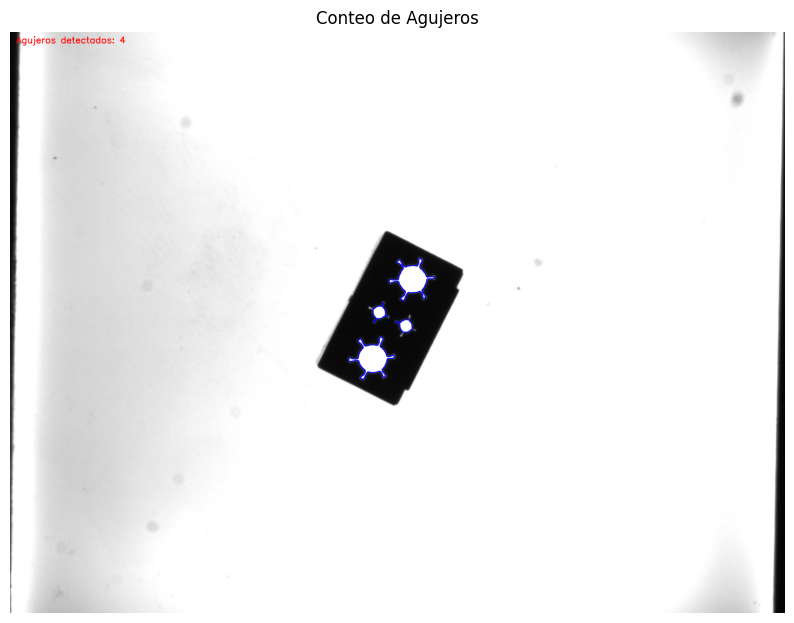

In [27]:
num_agujeros = len(contornos_filtrados)

img_conteo = cv.cvtColor(img_backlight, cv.COLOR_GRAY2BGR)

cv.putText(
    img_conteo,
    f'Agujeros detectados: {num_agujeros}',
    (20,40),
    cv.FONT_HERSHEY_SIMPLEX,
    1,
    (255,0,0),
    2
)

cv.drawContours(img_conteo, contornos_filtrados, -1, (0,0,255), 2)

mostrar_imagen('Conteo de Agujeros', img_conteo)

## Medición por Contorno: Área y centroide.

Reporte de mediciones
Agujero #1: Área = 8414.00 px, Centro = (1211, 1093)
Agujero #2: Área = 1424.50 px, Centro = (1323, 984)
Agujero #3: Área = 1458.00 px, Centro = (1234, 939)
Agujero #4: Área = 8027.00 px, Centro = (1345, 828)


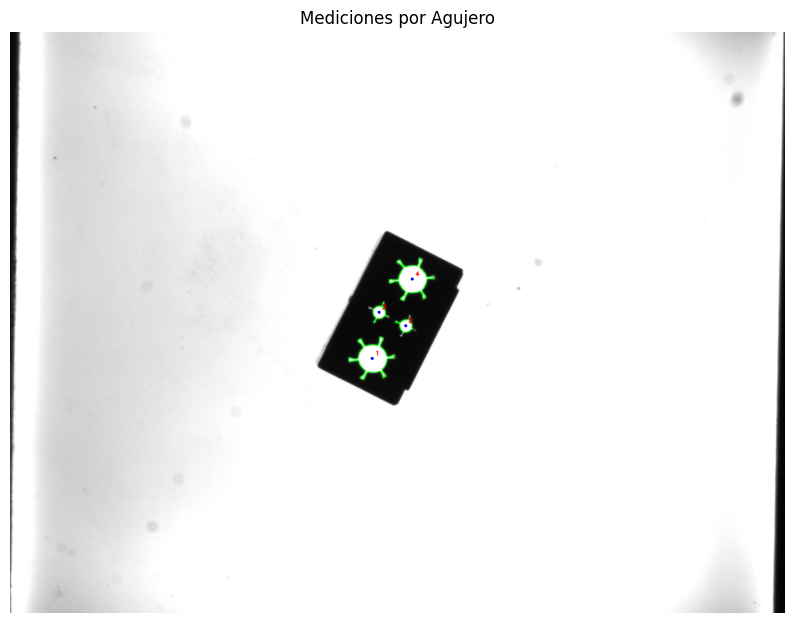

In [29]:
img_mediciones = cv.cvtColor(img_backlight, cv.COLOR_GRAY2BGR)
indice_agujero = 0

print("Reporte de mediciones")

for cnt in contornos_filtrados:
    indice_agujero += 1

    area = cv.contourArea(cnt)
    M = cv.moments(cnt)

    if M['m00'] != 0:
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
    else:
        cx, cy = 0, 0

    print(f"Agujero #{indice_agujero}: Área = {area:.2f} px, Centro = ({cx}, {cy})")

    cv.drawContours(img_mediciones, [cnt], -1, (0,255,0), 2)
    cv.circle(img_mediciones, (cx, cy), 5, (0,0,255), -1)
    cv.putText(img_mediciones, str(indice_agujero), (cx+10, cy-10),cv.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)

mostrar_imagen('Mediciones por Agujero', img_mediciones)

**¿Por qué no son iguales las áreas?**
**¿Qué estamos tomando como area?**